In [2]:
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
def lines_to_links(n, index=None):

    if index is None:
        index = n.lines.index

    overlap = (
        n.links.columns.intersection(n.lines.columns).tolist() +
        n.lines.columns[n.lines.columns.str.contains('s_')].tolist()
    )

    linelinks = n.lines.loc[index, overlap].copy()

    linelinks.loc[:, 'efficiency'] = 1.
    linelinks.loc[:, 'underwater_fraction'] = 0

    linelinks.columns = linelinks.columns.str.replace('s_', 'p_')    
    diff = n.links.columns.difference(linelinks.columns)

    linelinks.loc[:, diff] = n.links.iloc[0].loc[diff].values

    n.add(
        'Link', 'dummy', bus0=n.buses.index[0], bus1=n.buses.index[1],
    )

    new_links = pd.concat((
            n.links.loc[['dummy']],
            linelinks
        )).iloc[1:]

    n.links.drop('dummy', inplace=True)

    for name, kwargs in new_links.iterrows():

        kwargs = kwargs.to_dict()
        n.add('Link', name, **kwargs)

        n.remove(
            'Line',
            name
        )

In [11]:
path = Path.cwd().parent / 'results' / 'prenetworks' / '2024-03-22'
n1 = pypsa.Network(path / 'network_nodal_s.nc')

lines_to_links(n1, n1.lines.index)

INFO:pypsa.io:Imported network network_nodal_s.nc has buses, carriers, generators, lines, links, loads, storage_units


False


In [ ]:
n1 = pypsa.Network(path / 'network_nodal_s.nc')

INFO:pypsa.io:Imported network network_nodal_s.nc has buses, carriers, generators, lines, links, loads, storage_units


In [163]:
n1.export_to_netcdf('hold_network.nc')

INFO:pypsa.io:Exported network 'hold_network.nc' contains: loads, carriers, links, storage_units, generators, buses


<xarray.Dataset> Size: 374kB
Dimensions:                                (snapshots: 48,
                                            investment_periods: 0,
                                            loads_i: 390, loads_t_p_set_i: 390,
                                            carriers_i: 23, links_i: 419,
                                            links_t_p_set_i: 3,
                                            storage_units_i: 108,
                                            generators_i: 307,
                                            generators_t_p_max_pu_i: 247,
                                            generators_t_marginal_cost_i: 5,
                                            buses_i: 285)
Coordinates:
  * snapshots                              (snapshots) int64 384B 0 1 ... 46 47
  * investment_periods                     (investment_periods) int64 0B 
  * loads_i                                (loads_i) object 3kB '8838' ... 'n...
  * loads_t_p_set_i                        (loads_t_p_set_i) object 3kB '8838...
  * carriers_i                             (carriers_i) object 184B 'intercon...
  * links_i                                (links_i) object 3kB '8009' ... '5...
  * links_t_p_set_i                        (links_t_p_set_i) object 24B 'Elec...
  * storage_units_i                        (storage_units_i) object 864B 'BFS...
  * generators_i                           (generators_i) object 2kB 'CMSTW-1...
  * generators_t_p_max_pu_i                (generators_t_p_max_pu_i) object 2kB ...
  * generators_t_marginal_cost_i           (generators_t_marginal_cost_i) object 40B ...
  * buses_i                                (buses_i) object 2kB '8838' ... 'F...
Data variables: (12/53)
    snapshots_snapshot                     (snapshots) datetime64[ns] 384B 20...
    snapshots_objective                    (snapshots) float64 384B 1.0 ... 1.0
    snapshots_generators                   (snapshots) float64 384B 1.0 ... 1.0
    snapshots_stores                       (snapshots) float64 384B 1.0 ... 1.0
    investment_periods_objective           (investment_periods) float64 0B 
    investment_periods_years               (investment_periods) float64 0B 
    ...                                     ...
    generators_t_marginal_cost             (snapshots, generators_t_marginal_cost_i) float64 2kB ...
    buses_v_nom                            (buses_i) float64 2kB 380.0 ... 380.0
    buses_x                                (buses_i) float64 2kB -2.17 ... -1.71
    buses_y                                (buses_i) float64 2kB 53.24 ... 49.64
    buses_carrier                          (buses_i) object 2kB 'AC' ... 'ele...
    buses_country                          (buses_i) object 2kB 'GB' ... 'Fra...
Attributes:
    network_name:           PyPSA-Eur
    network_pypsa_version:  0.31.0
    network_srid:           4326
    crs:                    {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geo...
    meta:                   {"scenario": {"start": "2022-02-01", "end": "2022...

<Axes: xlabel='snapshot'>

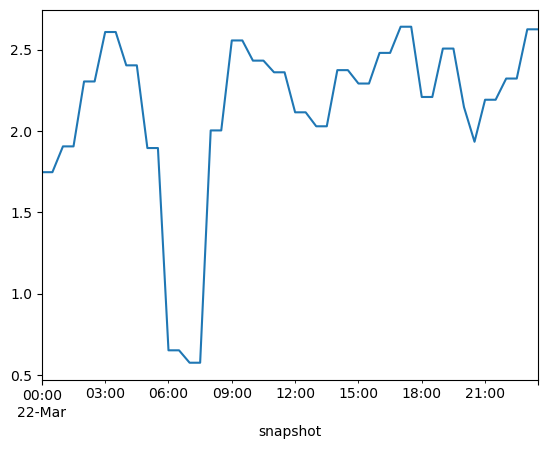

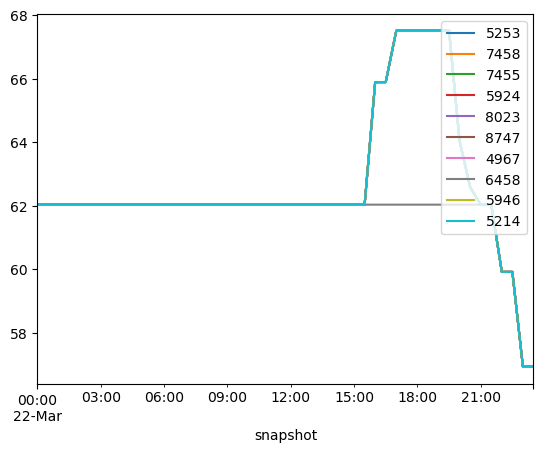

In [159]:
n1.buses_t.marginal_price.std(axis=1).plot()
n1.buses_t.marginal_price.T.sample(10).T.plot()

In [160]:
import geopandas as gpd
regions = gpd.read_file(path / 'regions_onshore_s.geojson').set_index('name')

INFO:pypsa.io:Imported network hold_network.nc has buses, carriers, generators, links, loads, storage_units
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 39.90it/s]
INFO:linopy.io: Writing time: 1.28s
INFO:linopy.solvers:Log file at C:\Users\lukas\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 50400 primals, 120115 duals
Objective: -1.56e+07
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix

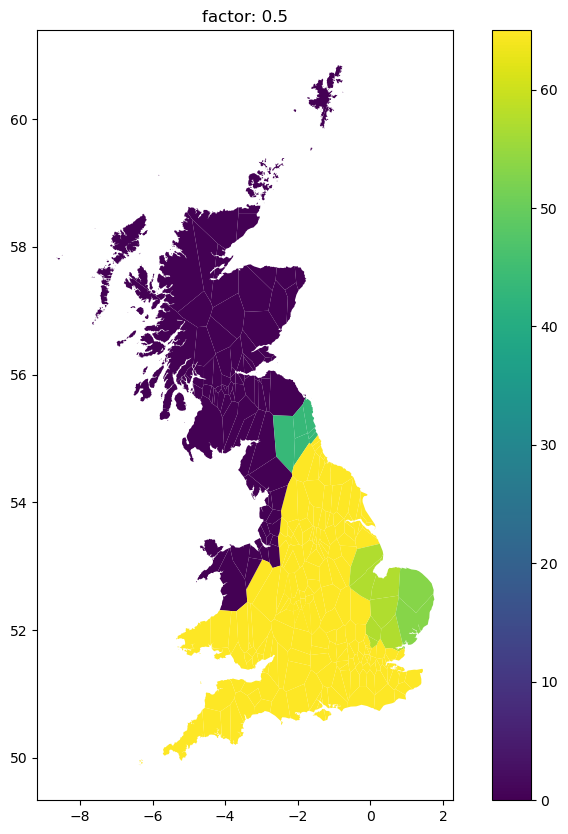

In [ ]:
for factor in np.linspace(0.5, 2, 20):

    n1 = pypsa.Network('hold_network.nc')

    n1.links.loc[n1.links.carrier == 'AC', 'p_nom'] *= factor
    n1.optimize()

    regions['mp'] = n1.buses_t.marginal_price.mean().loc[regions.index]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    regions.plot(column='mp', ax=ax, legend=True, vmin=0, vmax=65)
    ax.set_title(f'factor: {factor}')
    plt.show()

    break

In [9]:
from copy import deepcopy

n1 = pypsa.Network(path / 'network_nodal_s.nc')

national = deepcopy(n1)
national.lines.loc[:, 's_nom'] = np.inf
national.optimize()

INFO:pypsa.io:Imported network network_nodal_s.nc has buses, carriers, generators, lines, links, loads, storage_units
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 35.33it/s]
INFO:linopy.io: Writing time: 1.59s
INFO:linopy.solvers:Log file at C:\Users\lukas\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 50400 primals, 126403 duals
Objective: -2.83e+07
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Gen

('ok', 'optimal')

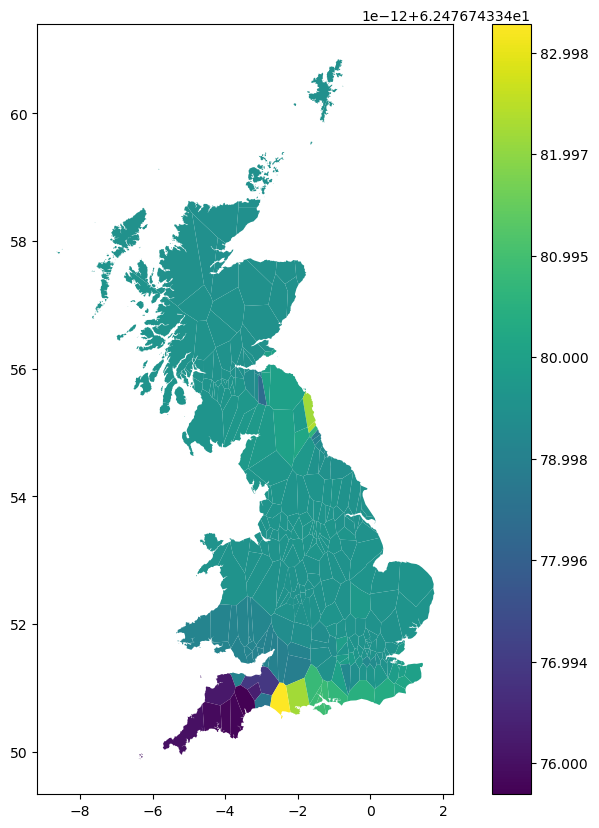

In [11]:
regions['mp'] = national.buses_t.marginal_price.mean().loc[regions.index]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
regions.plot(column='mp', ax=ax, legend=True)
plt.show()

In [15]:
national.buses['v_nom'].value_counts()

v_nom
380.0    285
Name: count, dtype: int64

In [21]:
national.lines[['v_nom', 'x_pu_eff', 'r_pu_eff']]#.value_counts()

,v_nom,x_pu_eff,r_pu_eff
Line,,,
11524,380.0,0.000038,4.655791e-06
8704,380.0,0.000083,1.008733e-05
8703,380.0,0.000079,9.591865e-06
14745,380.0,0.000058,7.120946e-06
2144,380.0,0.000017,2.050935e-06
...,...,...,...
5218,380.0,0.000014,1.689897e-06
6216,380.0,0.000007,8.388767e-07
6218,380.0,0.000009,1.042237e-06


In [60]:
national.lines.head()

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,i_nom,v_nom
Line,,,,,,,,,,,,,,,,,,,,,
11524,4950,4951,Al/St 240/40 4-bundle 380.0,5.512829,0.672296,0.0,0.000389,inf,0.0,False,...,0,0.000038,0.000005,0.0,56.117141,0.000038,0.000005,inf,2.58,380.0
8704,4951,4955,Al/St 240/40 4-bundle 380.0,11.944200,1.456610,0.0,0.000210,inf,0.0,False,...,0,0.000083,0.000010,0.0,30.396117,0.000083,0.000010,inf,2.58,380.0
8703,4955,4956,Al/St 240/40 4-bundle 380.0,11.357535,1.385065,0.0,0.000200,inf,0.0,False,...,0,0.000079,0.000010,0.0,28.903148,0.000079,0.000010,inf,2.58,380.0
14745,4951,4956,Al/St 240/40 4-bundle 380.0,8.431769,1.028265,0.0,0.000594,inf,0.0,False,...,0,0.000058,0.000007,0.0,85.830126,0.000058,0.000007,inf,2.58,380.0
2144,4952,4958,Al/St 240/40 4-bundle 380.0,2.428471,0.296155,0.0,0.000060,inf,0.0,False,...,0,0.000017,0.000002,0.0,8.666661,0.000017,0.000002,inf,2.58,380.0


In [ ]:
def e